In [97]:
import sys,os
from math import *
from pathlib import Path

import h5py
import numpy as np
from numpy import square as sqr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from copy import deepcopy
#import foxlink
from foxlink import fp_graphs as fpg
from foxlink.fp_graphs import graph_vs_time, graph_xl_dens
import importlib
#importlib.reload(foxlink.FP_analysis)
from foxlink.FP_analysis import FPAnalysis, LineDataUnits
from foxlink.stylelib.ase1_styles import ase1_runs_stl, ase1_sims_stl


# Graphing functions

In [98]:
def graph_comparison_vs_time(ax, time_arr, val_arr1, val_arr2, color='b'):
    ax.set_xlabel('Time (sec)')
    ax.tick_params(axis='y', labelcolor=color)
    comp_arr = np.abs(val_arr2-val_arr1)
    s1 = ax.scatter(time_arr, val_arr1, c=color, marker='o')
    s2 = ax.scatter(time_arr, val_arr2, facecolors='none',edgecolors=color)
    ax2 = ax.twinx()
    scomp = ax2.scatter(time_arr, comp_arr,c='r', marker='+')
    ax2.set_ylabel('Absolute Difference', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    return s1, s2

In [99]:
def PDE_ME_compare_graph_vs_time(fig, axarr, PDE_data, ME_data):
    time = PDE_data['time']
    PDE_sep_arr = PDE_data['Analysis/rod_analysis/center_separation'][:]
    ME_sep_arr = ME_data['Analysis/rod_analysis/center_separation'][:]
    graph_comparison_vs_time(axarr[0], time, PDE_sep_arr, ME_sep_arr)
    axarr[0].set_ylabel(r'Rod center separation (nm)')
    axarr[0].legend(('PDE data', 'ME data', 'error'))

    PDE_ang_arr = PDE_data['Analysis/rod_analysis/angle_between'][:]
    ME_ang_arr = ME_data['Analysis/rod_analysis/angle_between'][:]
    graph_comparison_vs_time(axarr[1], time, PDE_ang_arr, ME_ang_arr)
    axarr[1].set_ylabel(r'Angle between rods (rads)')
    axarr[1].legend(('PDE data', 'ME data', 'error'))

    PDE_rho_arr = PDE_data['Analysis/XL_analysis/zeroth_moment'][:]
    ME_rho_arr = ME_data['XL_data/zeroth_moment'][:]
    graph_comparison_vs_time(axarr[3], time, PDE_rho_arr, ME_rho_arr)
    axarr[3].set_ylabel(r'Motor number')
    axarr[3].legend(('PDE data', 'ME data', 'error'))

    PDE_P1_arr = PDE_data['Analysis/XL_analysis/first_moments'][:,0]
    ME_P1_arr = ME_data['XL_data/first_moments'][:,0]
    graph_comparison_vs_time(axarr[4], time, PDE_P1_arr, ME_P1_arr, color='g')
    axarr[4].set_ylabel(r'First moment $P_1$ (nm)')
    axarr[4].legend(('PDE data', 'ME data', 'error'))

    PDE_P2_arr = PDE_data['Analysis/XL_analysis/first_moments'][:,1]
    ME_P2_arr = ME_data['XL_data/first_moments'][:,1]
    graph_comparison_vs_time(axarr[5], time, PDE_P2_arr, ME_P2_arr, color='tab:purple')
    axarr[5].set_ylabel(r'First moment $P_2$ (nm)')
    axarr[5].legend(('PDE data', 'ME data', 'error'))

    PDE_mu11_arr = PDE_data['Analysis/XL_analysis/second_moments'][:,0]
    ME_mu11_arr = ME_data['XL_data/second_moments'][:,0]
    graph_comparison_vs_time(axarr[6], time, PDE_mu11_arr, ME_mu11_arr,)
    axarr[6].set_ylabel(r'Second moment $\mu_{11}$ (nm)')
    axarr[6].legend(('PDE data', 'ME data', 'error'))

    PDE_mu20_arr = PDE_data['Analysis/XL_analysis/second_moments'][:,1]
    ME_mu20_arr = ME_data['XL_data/second_moments'][:,1]
    graph_comparison_vs_time(axarr[7], time, PDE_mu20_arr, ME_mu20_arr, color='tab:green')
    axarr[7].set_ylabel(r'Second moment $\mu_{20}$ (nm)')
    axarr[7].legend(('PDE data', 'ME data', 'error'))

    PDE_mu02_arr = PDE_data['Analysis/XL_analysis/second_moments'][:,2]
    ME_mu02_arr = ME_data['XL_data/second_moments'][:,2]
    graph_comparison_vs_time(axarr[8], time, PDE_mu02_arr, ME_mu02_arr, color='tab:purple')
    axarr[8].set_ylabel(r'Second moment $\mu_{02}$ (nm)')
    axarr[8].legend(('PDE data', 'ME data', 'error'))

In [132]:
def PDE_compare_graph_vs_time(fig, axarr, PDE_data1, PDE_data2, labels=['data 1','data 2']):
    time = PDE_data1['time']
    
    sep_arr1 = PDE_data1['Analysis/rod_analysis/center_separation'][:]
    sep_arr2 = PDE_data2['Analysis/rod_analysis/center_separation'][:]
    graph_comparison_vs_time(axarr[0], time, sep_arr1, sep_arr2)
    axarr[0].set_ylabel(r'Rod center separation (nm)')
    axarr[0].legend(labels)

    ang_arr1 = PDE_data1['Analysis/rod_analysis/angle_between'][:]
    ang_arr2 = PDE_data2['Analysis/rod_analysis/angle_between'][:]
    graph_comparison_vs_time(axarr[1], time, ang_arr1, ang_arr2)
    axarr[1].set_ylabel(r'Angle between rods (rads)')
    axarr[1].legend(labels)
    #axarr[1].legend(('PDE data', 'ME data', 'error'))
    
    force_arr1 = np.linalg.norm(PDE_data1['Interaction_data/force_data'][:,0,:], axis=1)
    force_arr2 = np.linalg.norm(PDE_data2['Interaction_data/force_data'][:,0,:], axis=1)
    graph_comparison_vs_time(axarr[2], time, force_arr1, force_arr2)
    axarr[2].set_ylabel(r'Magnitude of force on rods (rads)')
    axarr[2].legend(labels)
    #axarr[1].legend(('PDE data', 'ME data', 'error'))

    rho_arr1 = PDE_data1['Analysis/XL_analysis/zeroth_moment'][:]
    rho_arr2 = PDE_data2['Analysis/XL_analysis/zeroth_moment'][:]
    graph_comparison_vs_time(axarr[3], time, rho_arr1, rho_arr2)
    axarr[3].set_ylabel(r'Motor number')
    axarr[3].legend(labels)
    #axarr[3].legend(('PDE data', 'ME data', 'error'))

    P1_arr1 = PDE_data1['Analysis/XL_analysis/first_moments'][:,0]
    P1_arr2 = PDE_data2['Analysis/XL_analysis/first_moments'][:,0]
    graph_comparison_vs_time(axarr[4], time, P1_arr1, P1_arr2, color='tab:green')
    axarr[4].set_ylabel(r'First moment $P_1$ (nm)')
    axarr[4].legend(labels)
    #axarr[4].legend(('PDE data', 'ME data', 'error'))

    P2_arr1 = PDE_data1['Analysis/XL_analysis/first_moments'][:,1]
    P2_arr2 = PDE_data2['Analysis/XL_analysis/first_moments'][:,1]
    graph_comparison_vs_time(axarr[5], time, P2_arr1, P2_arr2, color='tab:purple')
    axarr[5].set_ylabel(r'First moment $P_2$ (nm)')
    axarr[5].legend(labels)
    #axarr[5].legend(('PDE data', 'ME data', 'error'))

    mu11_arr1 = PDE_data1['Analysis/XL_analysis/second_moments'][:,0]
    mu11_arr2 = PDE_data2['Analysis/XL_analysis/second_moments'][:,0]
    graph_comparison_vs_time(axarr[6], time, mu11_arr1, mu11_arr2)
    axarr[6].set_ylabel(r'Second moment $\mu_{11}$ (nm)')
    axarr[6].legend(labels)
    #axarr[6].legend(('PDE data', 'ME data', 'error'))

    mu20_arr1 = PDE_data1['Analysis/XL_analysis/second_moments'][:,1]
    mu20_arr2 = PDE_data2['Analysis/XL_analysis/second_moments'][:,1]
    graph_comparison_vs_time(axarr[7], time, mu20_arr1, mu20_arr2, color='tab:green')
    axarr[7].set_ylabel(r'Second moment $\mu_{20}$ (nm)')
    axarr[7].legend(labels)
    #axarr[7].legend(('PDE data', 'ME data', 'error'))

    mu02_arr1 = PDE_data1['Analysis/XL_analysis/second_moments'][:,2]
    mu02_arr2 = PDE_data2['Analysis/XL_analysis/second_moments'][:,2]
    graph_comparison_vs_time(axarr[8], time, mu02_arr1, mu02_arr2, color='tab:purple')
    axarr[8].set_ylabel(r'Second moment $\mu_{02}$ (nm)')
    axarr[8].legend(labels)
    #axarr[8].legend(('PDE data', 'ME data', 'error'))

# Data compare test

## PDE vs PDE Stationary

### Anti-parallel

In [133]:
# Time difference data
PDE_antipara_dt0001 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_base.h5"))
PDE_antipara_dt00005 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_dt.00005.h5"))

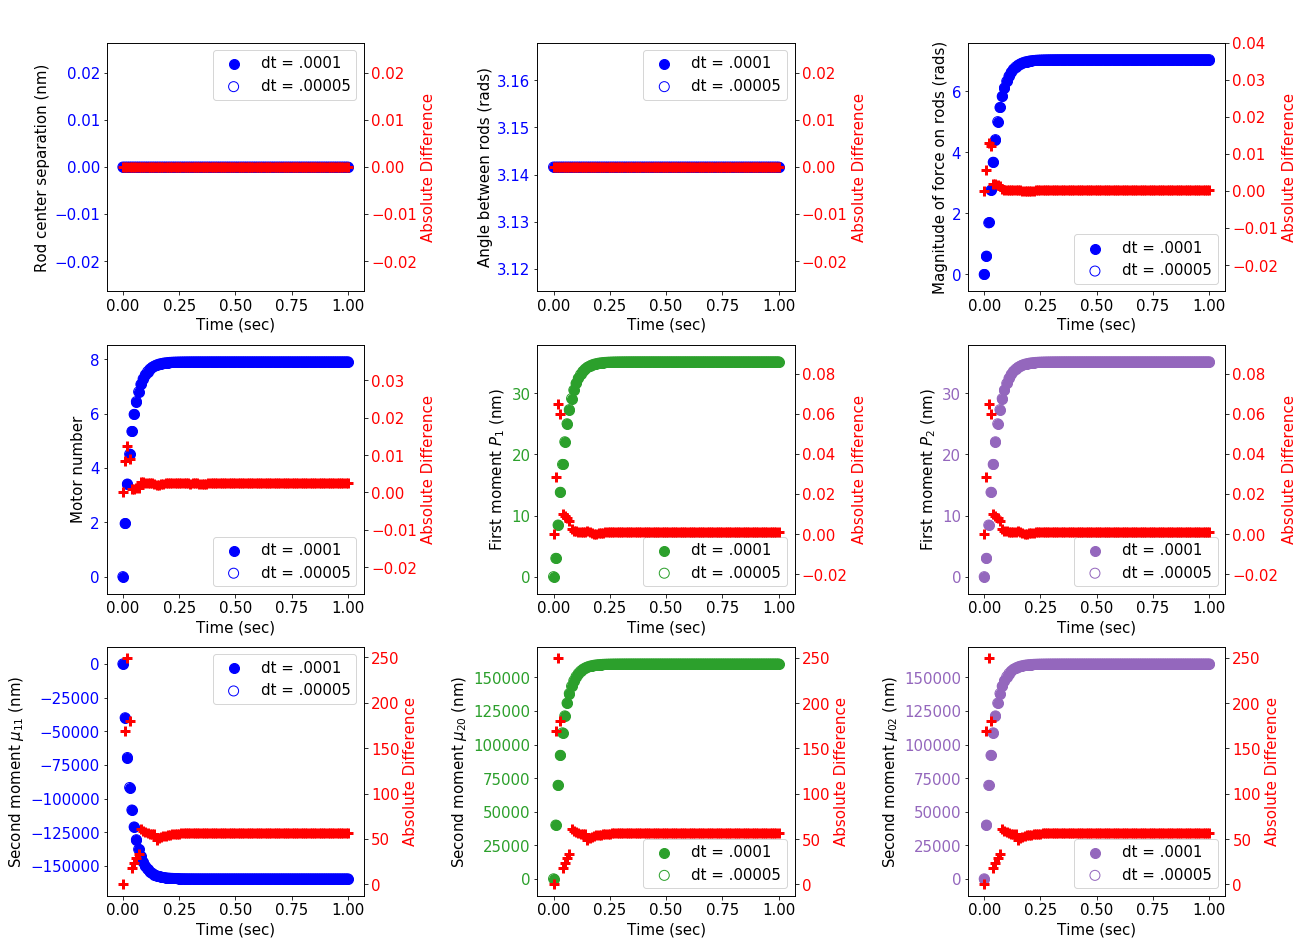

In [134]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_compare_graph_vs_time(fig, axarr, PDE_antipara_dt0001, PDE_antipara_dt00005, labels=['dt = .0001', 'dt = .00005'])

In [135]:
PDE_antipara_dt0001.close()
PDE_antipara_dt00005.close()

In [136]:
# Spatial difference data ds=1 to ds=2
PDE_antipara_ds1 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_base.h5"))
PDE_antipara_ds2 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_ds2.0.h5"))

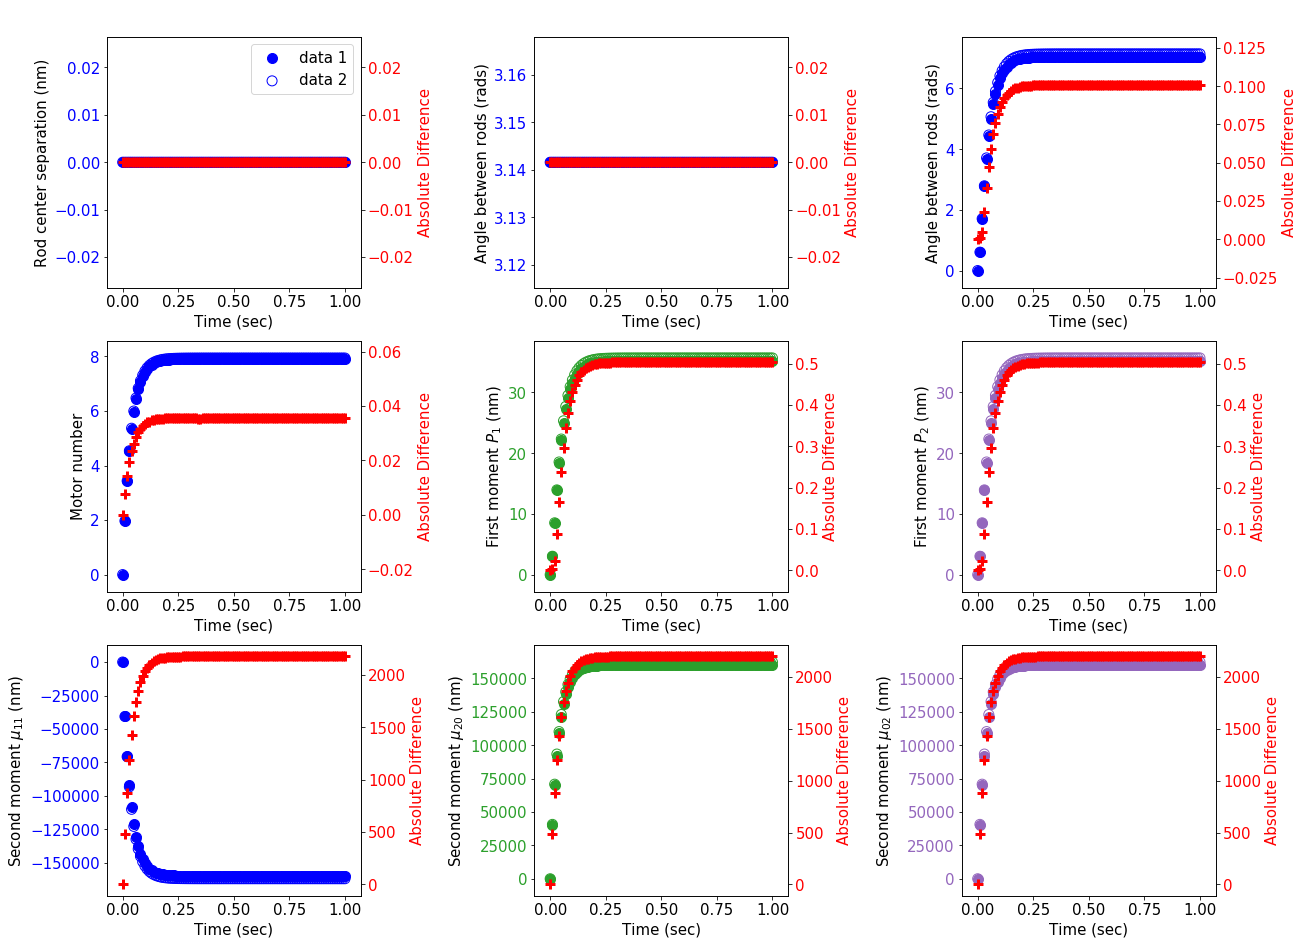

In [125]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_compare_graph_vs_time(fig, axarr, PDE_antipara_ds1, PDE_antipara_ds2, labels=['ds = 1.0 nm', 'ds = 2.0 nm'])

In [126]:
PDE_antipara_ds1.close()
PDE_antipara_ds2.close()

In [129]:
# Spatial difference data ds=1 to ds=.5
PDE_antipara_ds1 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_base.h5"))
PDE_antipara_ds_5 = h5py.File(Path("../tests/integration_tests/PDE_stat_compare/antiparallel/FPGenOrientMotorUWSolver_ds.5.h5"))

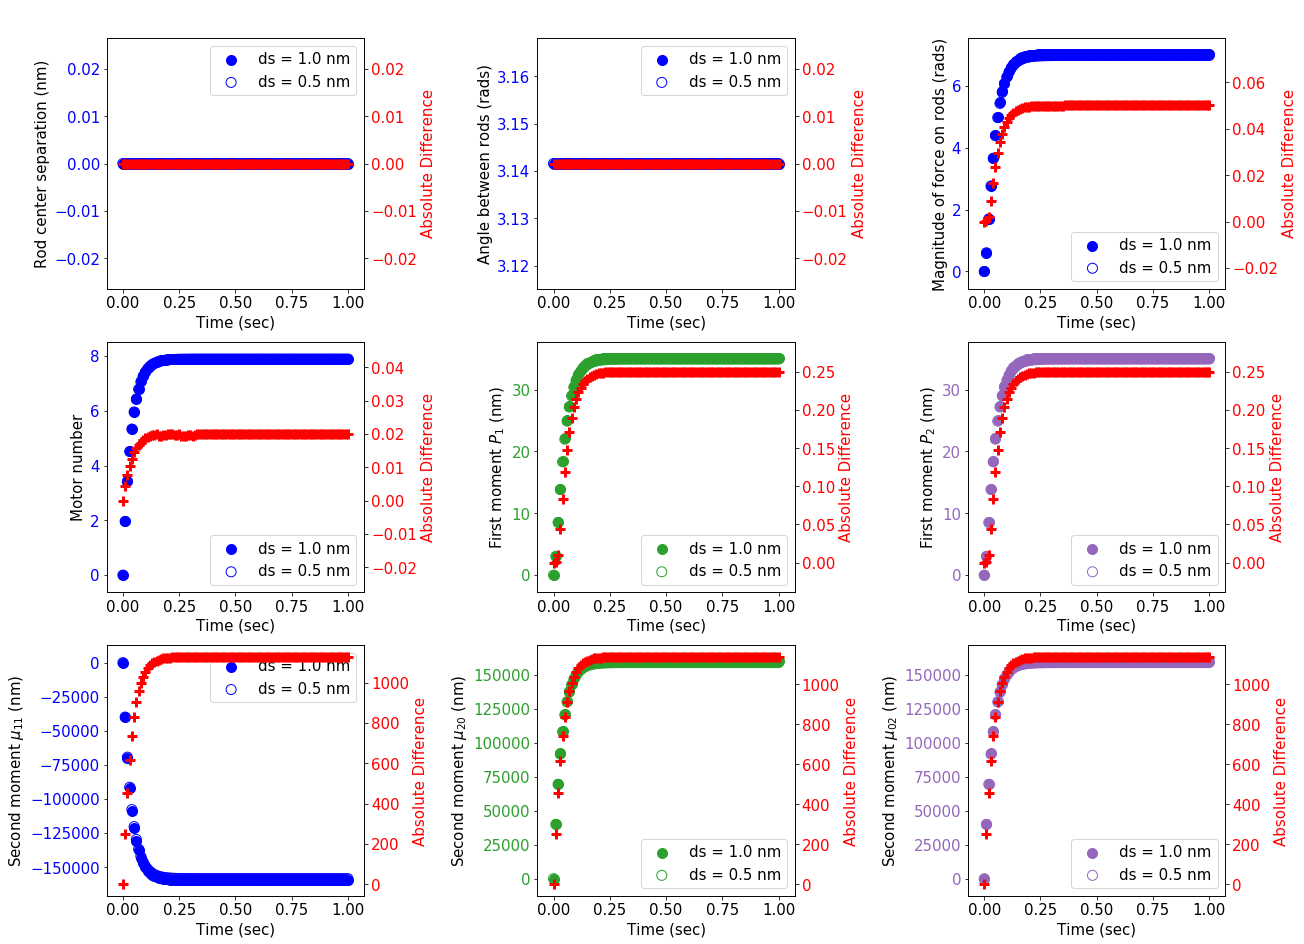

In [137]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_compare_graph_vs_time(fig, axarr, PDE_antipara_ds1, PDE_antipara_ds_5, labels = ['ds = 1.0 nm', 'ds = 0.5 nm'])

### Parallel

### Perpendicular

## PDE vs PDE Motion

### Anti-parallel

### Parallel

### Perpendicular

## ME vs ME Stationary

### Anti-parallel

### Parallel

### Perpendicular

## ME vs ME Motion

### Anti-parallel

### Parallel

### Perpendicular

## PDE vs ME stationary

### Anti-parallel

In [142]:
# Load data
PDE_antipara_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/antiparallel/FPGenOrientMotorUWSolver.h5"),'r')
ME_antipara_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/antiparallel/MomentExpansionSolver.h5"),'r')

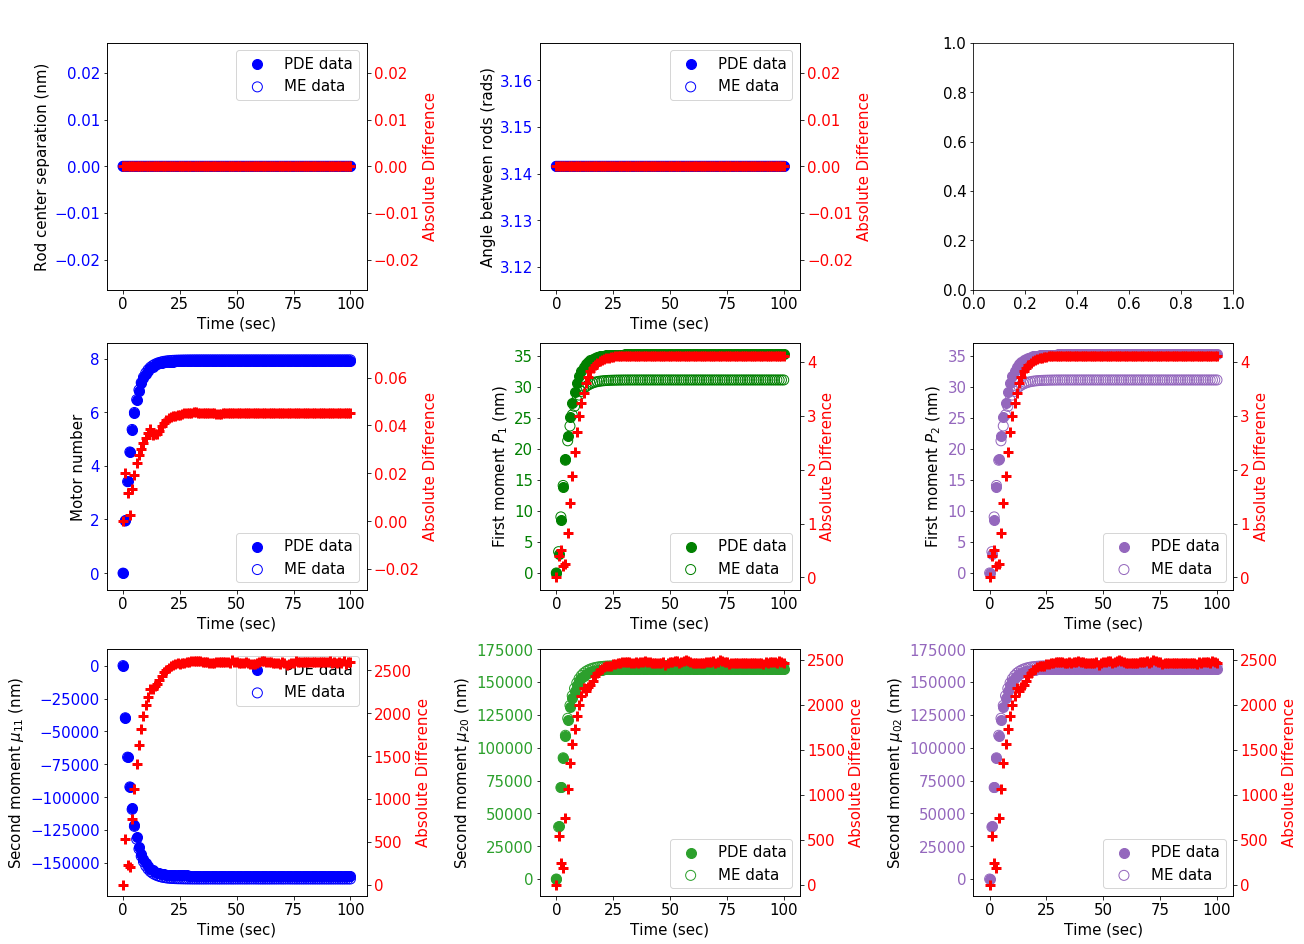

In [143]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_ME_compare_graph_vs_time(fig, axarr, PDE_antipara_data, ME_antipara_data)

In [144]:
PDE_antipara_data.close()
ME_antipara_data.close()

### Parallel

In [146]:
# Load data
PDE_para_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/parallel/FPGenOrientMotorUWSolver.h5"),'r')
ME_para_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/parallel/MomentExpansionSolver.h5"),'r')

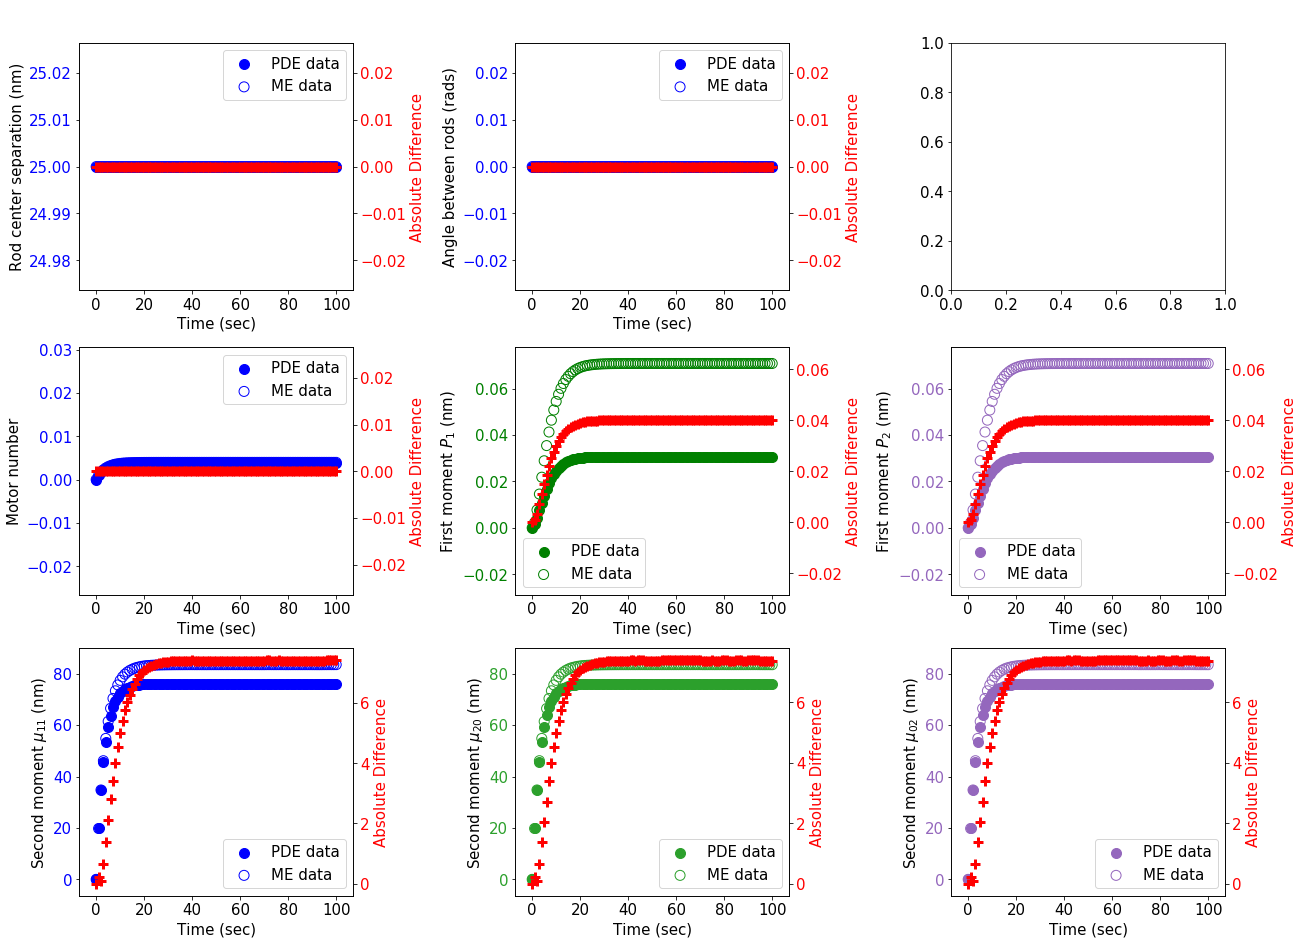

In [147]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_ME_compare_graph_vs_time(fig, axarr, PDE_para_data, ME_para_data)

In [144]:
PDE_para_data.close()
ME_para_data.close()

### Perpendicular

In [148]:
# Load data
PDE_perp_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/perpendicular/FPGenOrientMotorUWSolver.h5"),'r')
ME_perp_data = h5py.File(Path("../tests/integration_tests/PDE_ME_stat_compare/perpendicular/MomentExpansionSolver.h5"),'r')

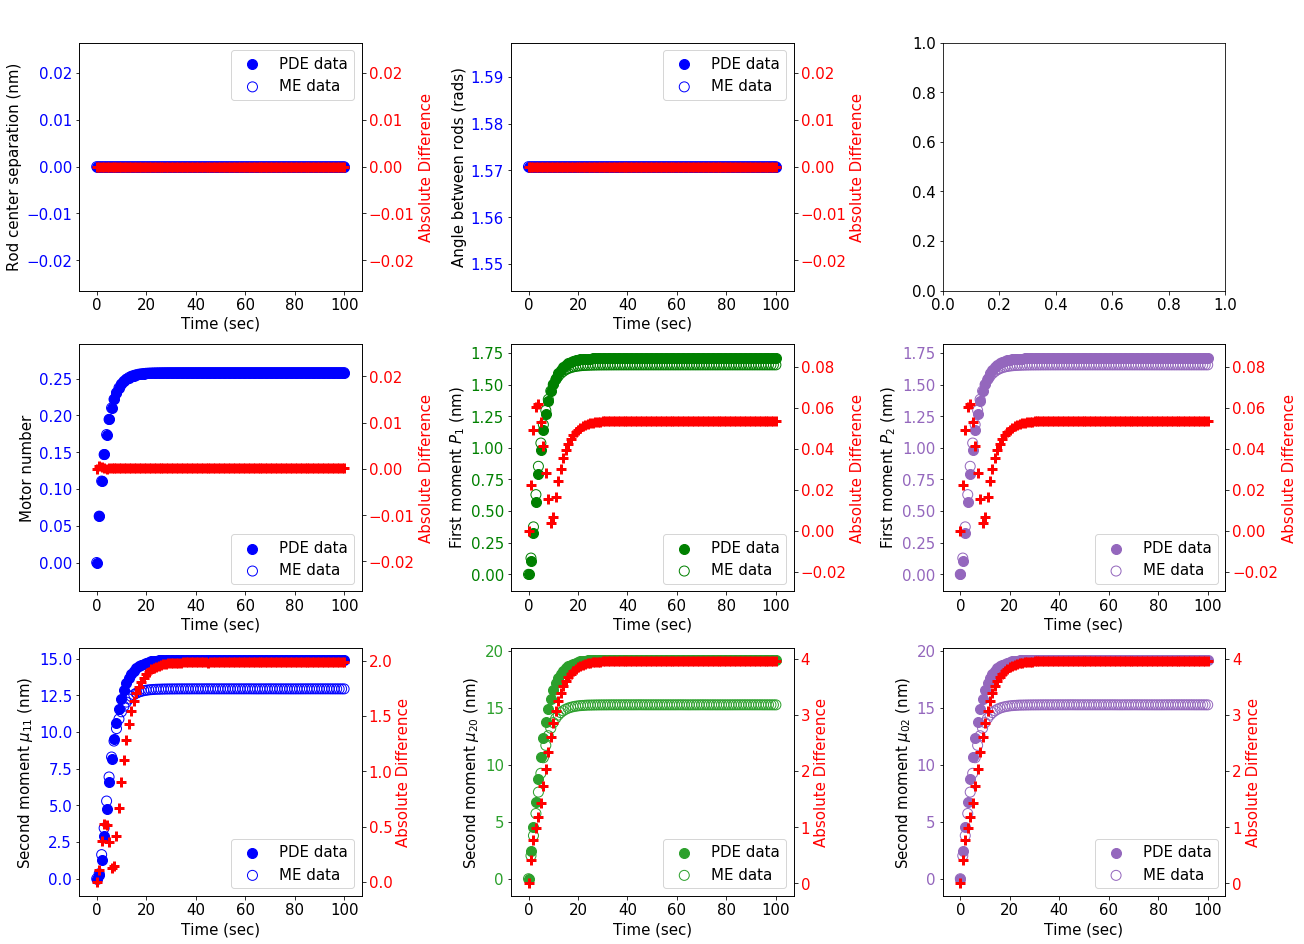

In [149]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_ME_compare_graph_vs_time(fig, axarr, PDE_perp_data, ME_perp_data)

In [144]:
PDE_perp_data.close()
ME_perp_data.close()

## PDE vs ME Motion

### Anti-parallel

In [100]:
# Load data
PDE_para_data = h5py.File(Path("../tests/integration_tests/PDE_ME_motion_compare/antiparallel/FPGenMotionMotorUWSolver.h5"),'r')
ME_para_data = h5py.File(Path("../tests/integration_tests/PDE_ME_motion_compare/antiparallel/MomentExpansionSolver.h5"),'r')

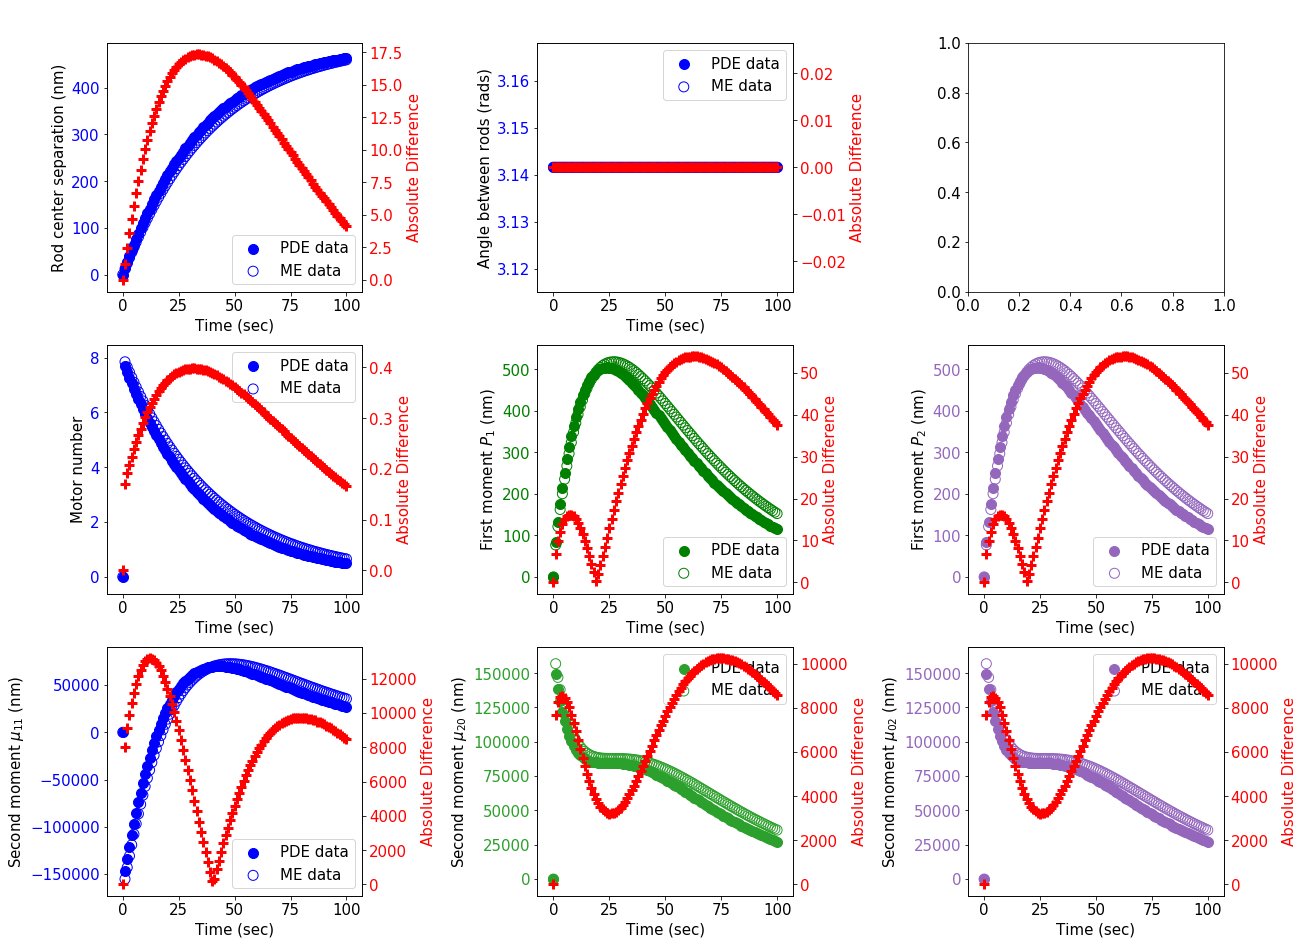

In [104]:
plt.style.use(ase1_runs_stl)
fig = plt.figure(constrained_layout=True, figsize=(18, 13))
gs = fig.add_gridspec(3, 3)
axarr = np.asarray([fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[0, 2]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1]),
                    fig.add_subplot(gs[1, 2]),
                    fig.add_subplot(gs[2, 0]),
                    fig.add_subplot(gs[2, 1]),
                    fig.add_subplot(gs[2, 2]),
                    ])
fig.suptitle(' ')

PDE_ME_compare_graph_vs_time(fig, axarr, PDE_para_data, ME_para_data)

In [91]:
PDE_para_data.close()
ME_para_data.close()

### Parallel

### Perpendicular